In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sklearn as sk
from sklearn.model_selection import train_test_split
import pickle

print(tf.__version__)

2024-09-24 10:30:02.723586: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-24 10:30:02.807873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 10:30:02.841959: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 10:30:02.852217: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-24 10:30:02.911826: I tensorflow/core/platform/cpu_feature_guar

2.17.0


In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpuid = 0 #int(args.gpu_id)                                                                                                                           
if gpus:
  # Restrict TensorFlow to only allocate X GB of memory on the first GPU                                                                              
  try:
    tf.config.set_visible_devices(gpus[gpuid], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[gpuid], True)
    '''
    tf.config.set_logical_device_configuration(
        gpus[gpuid],
        [tf.config.LogicalDeviceConfiguration(memory_limit=12000)])
    '''
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized                                                                                   
    print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1727195415.917085    5899 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727195416.026956    5899 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727195416.030329    5899 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727195416.033419    5899 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [6]:
#with tf.device('/job:localhost/replica:0/task:0/device:GPU:0'):
inputs = np.load("all_inputs_aug.npy")

In [7]:

targets = np.load("all_targets_aug.npy")
# train test split
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2)

In [5]:
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [6]:
# added more layers because original model didn't have enough downsampling
# old model had 266M params
conv_dim = 8
ff_dim = 32
k_dim = 5
pool_dim = 2
drop_rate = 0.1

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), activation='relu', input_shape=(1024, 1024, 1)),
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), activation='relu'),
  tf.keras.layers.MaxPooling2D((pool_dim, pool_dim)),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(ff_dim, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

/home/user/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1020, 1020, 8)  │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1016, 1016, 8)  │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 508, 508, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 508, 508, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2064512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │    66,064,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,066,265 (252.02 MB)

 Trainable params: 66,066,265 (252.02 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
conv_dim = 16
ff_dim = 32
k_dim = 21
pool_dim = 3
drop_rate = 0.2

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), activation='relu', input_shape=(512, 512, 1)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.AveragePooling2D(pool_dim,pool_dim),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), padding ='valid'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.AveragePooling2D(pool_dim,pool_dim),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), padding ='valid'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.AveragePooling2D(pool_dim,pool_dim),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(ff_dim, activation='relu'),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

/home/user/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 492, 492, 16)   │         7,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 492, 492, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 492, 492, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 164, 164, 16)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 164, 164, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 144, 144, 16)   │       112,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 144, 144, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 144, 144, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 48, 48, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 16)     │       112,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 9, 9, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 9, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1296)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        41,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 274,625 (1.05 MB)

 Trainable params: 274,529 (1.05 MB)

 Non-trainable params: 96 (384.00 B)

In [6]:
#model.compile(optimizer=Adam(learning_rate=1e-4),
#model.compile(optimizer=Adam(learning_rate=1e-2),
#model.compile(optimizer=Adam(learning_rate=1e-5),
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',  
              metrics=['accuracy'])

In [9]:
batchsize = 8
# buffer size is # of elements, not MB
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
train_dataset = train_dataset.shuffle(buffer_size=batchsize*2).batch(batchsize)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test))
test_dataset = test_dataset.shuffle(buffer_size=batchsize*2).batch(batchsize)

In [7]:
model_checkpoint = ModelCheckpoint(
  filepath='checkpoint2.model.keras',
  monitor='val_loss',
  mode='min',
  save_best_only=True)

optim = model.fit(X_train,y_train, 
                  epochs=100, 
                  validation_split =.2,
                  callbacks=[model_checkpoint])

Epoch 1/100


I0000 00:00:1726024990.363529    3506 service.cc:146] XLA service 0x7b8ad0012500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726024990.363558    3506 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2024-09-10 21:23:10.392015: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-10 21:23:10.554859: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-10 21:23:16.173658: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng2{k2=1,k3=0} for conv (f32[32,16,164,164]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,16,144,144]{3,2,1,0}, f32[16,16,21,21]{3,2,1,0}), window={size=21x21}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_opera

  4/137 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.6048 - loss: 0.6633 

I0000 00:00:1726025002.465255    3506 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7209 - loss: 0.5737

E0000 00:00:1726025013.433906    3506 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1726025013.516930    3506 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1726025014.749155    3506 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1726025014.828994    3506 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


137/137 ━━━━━━━━━━━━━━━━━━━━ 26s 92ms/step - accuracy: 0.7211 - loss: 0.5733 - val_accuracy: 0.5380 - val_loss: 2.5289
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.7955 - loss: 0.4266 - val_accuracy: 0.5490 - val_loss: 0.6962
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.8373 - loss: 0.3484 - val_accuracy: 0.6132 - val_loss: 1.2388
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.8688 - loss: 0.2916 - val_accuracy: 0.4693 - val_loss: 9.4900
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.8949 - loss: 0.2440 - val_accuracy: 0.5820 - val_loss: 1.5093
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9199 - loss: 0.1991 - val_accuracy: 0.5142 - val_loss: 2.6840
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9367 - loss: 0.1638 - val_accuracy: 0.4794 - val_loss: 5.7791
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9424 - loss: 0.1522 - val_accurac

In [10]:
optim.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

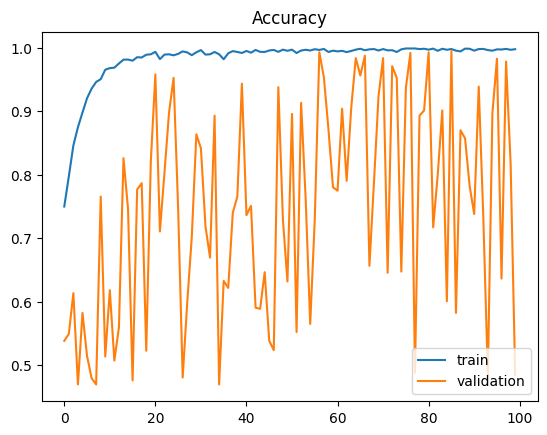

In [8]:
plt.plot(optim.history['accuracy'])
plt.plot(optim.history['val_accuracy'])
plt.legend(['train', 'validation'], loc='lower right')
plt.title('Accuracy')
plt.show()

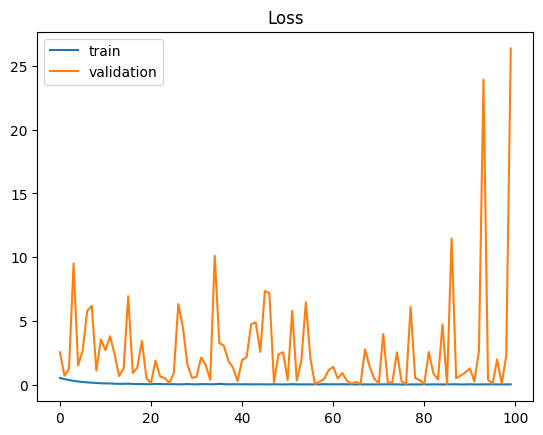

In [9]:
plt.plot(optim.history['loss'])
plt.plot(optim.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left')
plt.title('Loss')
plt.show()

In [10]:
np.array(optim.history['val_accuracy']).max()

0.994500458240509

In [4]:
from tensorflow.keras.models import load_model

best_model = load_model('checkpoint2.model.keras')

In [8]:
test_loss, test_acc = best_model.evaluate(X_test, y_test)

I0000 00:00:1727195519.711556    6455 service.cc:146] XLA service 0x793e180091f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727195519.711634    6455 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2024-09-24 10:31:59.729985: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-24 10:31:59.787379: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1727195520.096911    6455 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1727195520.179488    6455 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Sys

10/43 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 5.6459e-04

I0000 00:00:1727195521.585263    6455 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9995 - loss: 0.0109

E0000 00:00:1727195522.449560    6445 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1727195522.532480    6445 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9994 - loss: 0.0112


In [9]:
'Test loss:{0}, Test accuracy: {1}'.format(test_loss,test_acc)

'Test loss:0.01488907914608717, Test accuracy: 0.9992668628692627'

In [10]:
# Predict the values from the testing dataset
Y_pred_probs = best_model.predict(X_test)
Y_pred = np.array(Y_pred_probs>=.5)
# compute the confusion matrix
#confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred) 

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


Text(0, 0.5, 'freq')

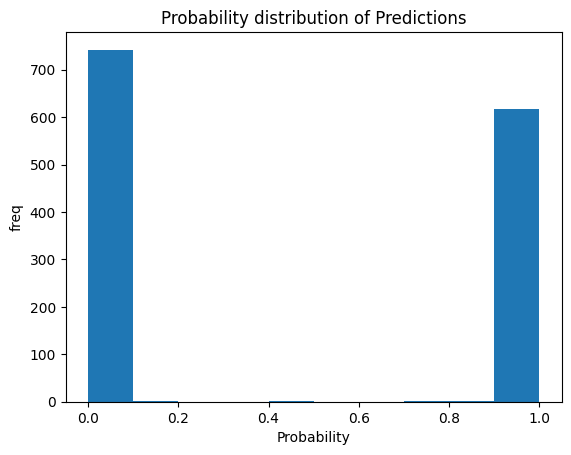

In [11]:
plt.hist(Y_pred_probs.flatten())
plt.title('Probability distribution of Predictions')
plt.xlabel('Probability')
plt.ylabel('freq')

Text(0, 0.5, 'freq')

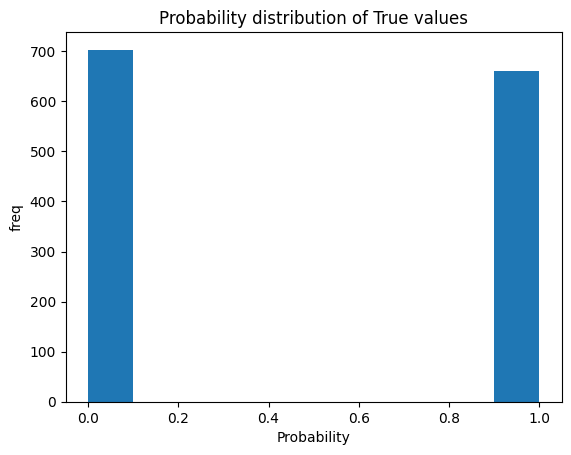

In [26]:
plt.hist(y_test)
plt.title('Probability distribution of True values')
plt.xlabel('Probability')
plt.ylabel('freq')

In [15]:
sum(y_test)

619.0

In [12]:
Y_pred = Y_pred.astype(float).flatten()

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, Y_pred) 

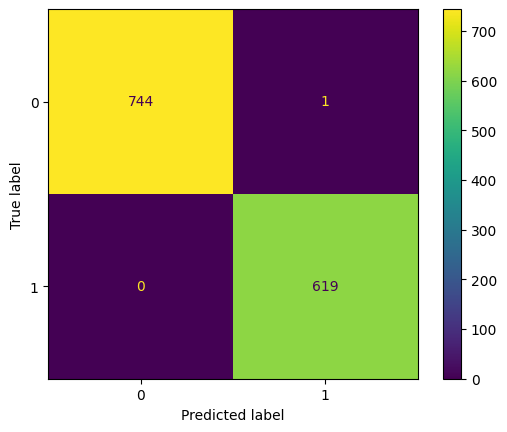

In [14]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [22]:
TP=641
TN=38
FP=665
FN=20

In [23]:
recall = TP/(TP+FN)
precision = TP/(TP+FP)

print(recall,precision)

0.9697428139183056 0.4908116385911179


In [25]:
accuracy = (TP+TN)/(TP+TN+FP+FN)
print(accuracy)

0.49780058651026393
